In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/tmp/ipykernel_874/3184238933.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import to_categorical

In [4]:
filenames = os.listdir('kaggle/dogs-vs-cats-redux-kernels-edition/train')
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append('1')
    else:
        categories.append('0')
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

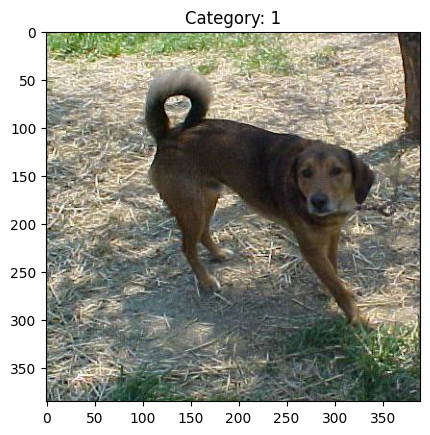

In [11]:
index = np.random.choice(df.index)
filename = df.loc[index, 'filename']
category = df.loc[index, 'category']
img = cv2.imread('kaggle/dogs-vs-cats-redux-kernels-edition/train/' + filename)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Change the color from BGR to RGB
plt.imshow(img_rgb)
plt.title(f'Category: {category}')
plt.show()
# test

In [12]:
df

,filename,category
0,cat.5663.jpg,0
1,dog.11277.jpg,1
2,cat.1240.jpg,0
3,dog.5978.jpg,1
4,cat.365.jpg,0
...,...,...
24995,dog.11600.jpg,1
24996,cat.9071.jpg,0
24997,dog.8132.jpg,1
24998,cat.5560.jpg,0


In [13]:
train_df,validate_df = train_test_split(df,train_size = 0.7, random_state = 42)
batch_size = 64

img_size = (128, 128)
channels = 3
img_shape = (img_size[0],img_size[1],channels)

In [14]:
# Create different ImageDataGenerator objects for training and testing/validation sets
tr_gen = ImageDataGenerator(rescale=1./255, 
                               shear_range=0.15, 
                               zoom_range=0.2, 
                               horizontal_flip=True)
ts_gen = ImageDataGenerator(rescale=1./255 )

In [15]:
# Specify the directory argument for each set
train_gen = tr_gen.flow_from_dataframe(dataframe = train_df, directory = 'kaggle/dogs-vs-cats-redux-kernels-edition/train',x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)
validate_gen = ts_gen.flow_from_dataframe(dataframe = validate_df, directory = 'kaggle/dogs-vs-cats-redux-kernels-edition/train', x_col = 'filename' ,y_col = 'category', target_size = img_size, class_mode = 'binary',color_mode = 'rgb'
                                      , shuffle = True, batch_size = batch_size)

Found 17500 validated image filenames belonging to 2 classes.
Found 7500 validated image filenames belonging to 2 classes.


In [16]:
from tensorflow.keras.applications import VGG16

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_shape)
base_model.trainable = False

model = Flatten()(base_model.output)
model = Dense(512, activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1, activation='sigmoid')(model)

model = Model(base_model.input, model)
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [21]:
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model3.h5', save_best_only=True, monitor='val_accuracy', mode='max')
history = model.fit(x= train_gen, epochs = 50 ,verbose = 1,validation_data = validate_gen, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
274/274 [==============================] - 37s 134ms/step - loss: 0.3306 - accuracy: 0.8535 - val_loss: 0.2474 - val_accuracy: 0.8955
Epoch 2/50


/home/xpert/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


274/274 [==============================] - 32s 117ms/step - loss: 0.2912 - accuracy: 0.8715 - val_loss: 0.2405 - val_accuracy: 0.8979
Epoch 3/50
274/274 [==============================] - 32s 117ms/step - loss: 0.2844 - accuracy: 0.8763 - val_loss: 0.2418 - val_accuracy: 0.8952
Epoch 4/50
274/274 [==============================] - 32s 117ms/step - loss: 0.2751 - accuracy: 0.8806 - val_loss: 0.2342 - val_accuracy: 0.9007
Epoch 5/50
274/274 [==============================] - 32s 117ms/step - loss: 0.2671 - accuracy: 0.8843 - val_loss: 0.2287 - val_accuracy: 0.9015
Epoch 6/50
274/274 [==============================] - 32s 116ms/step - loss: 0.2530 - accuracy: 0.8902 - val_loss: 0.2275 - val_accuracy: 0.9001
Epoch 7/50
274/274 [==============================] - 32s 117ms/step - loss: 0.2504 - accuracy: 0.8922 - val_loss: 0.2293 - val_accuracy: 0.9031
Epoch 8/50
274/274 [==============================] - 32s 117ms/step - loss: 0.2477 - accuracy: 0.8937 - val_loss: 0.2451 - val_accuracy: 0.8

In [22]:
test_filenames = os.listdir('kaggle/dogs-vs-cats-redux-kernels-edition/test')
test_df = pd.DataFrame({
    'filename': test_filenames
})

test_generator = ts_gen.flow_from_dataframe(
    test_df,
    'kaggle/dogs-vs-cats-redux-kernels-edition/test', 
    x_col='filename',
    y_col=None,
    target_size=(128, 128),
    class_mode=None,
    batch_size=64,
    shuffle=False
)

Found 12500 validated image filenames.


In [23]:
# Load the best model and predict the test data
best_model = tf.keras.models.load_model('best_model3.h5')
predict = best_model.predict(test_generator)
print(predict.shape)

196/196 [==============================] - 9s 48ms/step
(12500, 1)


In [24]:
predicted_classes = np.argmax(predict, axis=1)
print(predicted_classes)
predicted_classes.shape

[0 0 0 ... 0 0 0]


(12500,)

In [25]:
test_df['id'] = test_df['filename'].str.split('.').str[0]
test_df['label'] = predict

In [26]:
test_df.drop(columns=['filename'], inplace=True)
test_df.to_csv('submission_vgg.csv', index=False)

In [27]:
# draw confusion matrix
# get the true labels
y_true = validate_gen.classes

# get the predicted labels
y_pred = best_model.predict(validate_gen)
y_pred = y_pred > 0.5
y_pred = y_pred.astype(int)

# get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

118/118 [==============================] - 4s 32ms/step


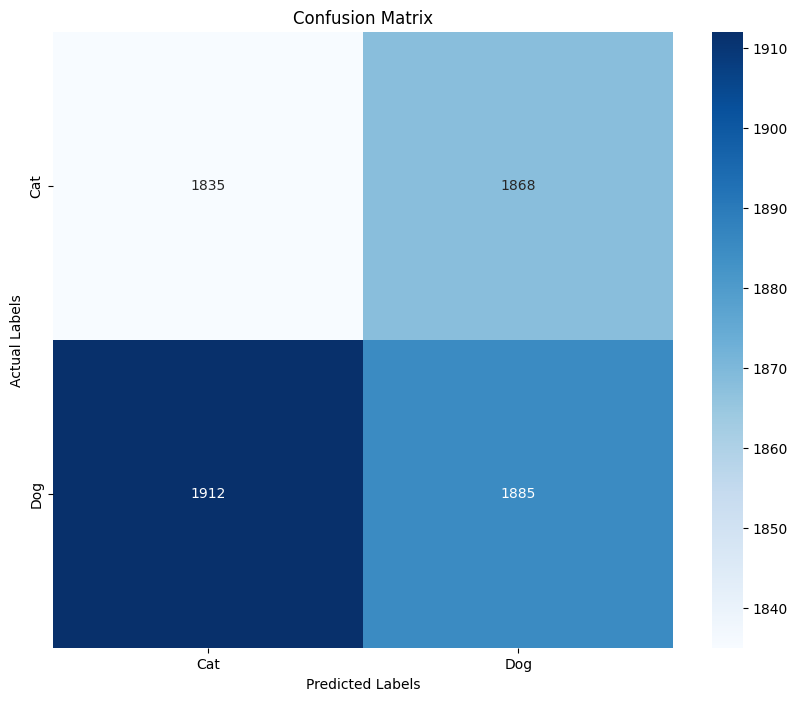

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.savefig('confusion_matrix.png')
plt.show()